In [1]:
import pandas as pd
import numpy as np
import re
from sentence_transformers.training_args import SentenceTransformerTrainingArguments, BatchSamplers

from sentence_transformers import (
    SentenceTransformer,
    # SentenceTransformerTrainer,
    # SentenceTransformerTrainingArguments,
    # SentenceTransformerModelCardData,
    util,
    # InputExample,
    # SentencesDataset,
    losses
)
from sentence_transformers.losses import MultipleNegativesRankingLoss
# from sentence_transformers.training_args import BatchSamplers
# from sentence_transformers.evaluation import TripletEvaluator
# from datasets import Dataset, load_dataset

import os
import matplotlib.pyplot as plt
import umap
import torch, os, scipy
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

# from torch.utils.data import DataLoader
# import torch

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/mateowheeler/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mateowheeler/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mateowheeler/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
import accelerate
import transformers

transformers.__version__, accelerate.__version__

('4.47.1', '0.26.0')

### Clustering Wine Review Descriptions

In [3]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [4]:
emb1 = model.encode("This wine has hints of fresh tennis ball.")
emb2 = model.encode("This wine has hints of a bowling alley.")

In [5]:
cos_sim = util.cos_sim(emb1, emb2)
print("Cosine-Similarity:", cos_sim)

Cosine-Similarity: tensor([[0.6378]])


In [6]:
# df0 = pd.read_csv('data/winemag-data_first150k.csv')
df = pd.read_csv('data/winemag-data-130k-v2.csv').drop(columns={'Unnamed: 0'})

# The 'first150k' file does not have the 'title'column
# df = pd.concat([df0,df1], ignore_index=True)

In [7]:
len(df)

129971

In [8]:
df.dtypes

country                   object
description               object
designation               object
points                     int64
price                    float64
province                  object
region_1                  object
region_2                  object
taster_name               object
taster_twitter_handle     object
title                     object
variety                   object
winery                    object
dtype: object

In [9]:
df.groupby('country')\
    .agg({'taster_name':'nunique', 
          'winery':'nunique', 
          'title':'nunique',
          'points':'mean',
          'price':'mean'})\
    .reset_index()

,country,taster_name,winery,title,points,price
0,Argentina,1,531,3543,86.710263,24.510117
1,Armenia,1,1,2,87.500000,14.500000
2,Australia,2,474,2183,88.580507,35.437663
3,Austria,2,228,3022,90.101345,30.762772
4,Bosnia and Herzegovina,2,1,2,86.500000,12.500000
5,Brazil,1,11,49,84.673077,23.765957
6,Bulgaria,4,24,132,87.936170,14.645390
7,Canada,6,45,226,89.369650,35.712598
8,Chile,3,317,4178,86.493515,20.786458
9,China,1,1,1,89.000000,18.000000


In [10]:
# remove French wines to enable data processing
df_filtered = df[df.country!='France'].reset_index()
# df_filtered = df.reset_index()

In [11]:
# how influential is each taster's description style on the entire corpus?
df_filtered.groupby('taster_name')['index'].count()

taster_name
Alexander Peartree      415
Anna Lee C. Iijima     4415
Anne Krebiehl MW       2290
Carrie Dykes            139
Christina Pickard         6
Fiona Adams              27
Jeff Jenssen            491
Jim Gordon             4177
Joe Czerwinski         3968
Kerin O’Keefe         10776
Lauren Buzzeo          1237
Matt Kettmann          6332
Michael Schachner     15114
Mike DeSimone           514
Paul Gregutt           9498
Roger Voss             6912
Sean P. Sullivan       4966
Susan Kostrzewa        1085
Virginie Boone         9537
Name: index, dtype: int64

In [12]:
len(df_filtered)

107878

#### Pre-process Description

In [13]:
stop = stopwords.words('english')
new_stopwords = ('wine','aromas')

for i in new_stopwords:
    stop.append(i)
print(stop)

df_filtered['desc_without_stopwords'] = df_filtered['description'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df_filtered['desc_without_stopwords']

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

0         Aromas include tropical fruit, broom, brimston...
1         This ripe fruity, smooth still structured. Fir...
2         Tart snappy, flavors lime flesh rind dominate....
3         Pineapple rind, lemon pith orange blossom star...
4         Much like regular bottling 2012, comes across ...
                                ...                        
107873    Intense wild cherry, baking spice, tilled soil...
107874    Blackberry, cassis, grilled herb toasted come ...
107875    A bouquet black cherry, tart cranberry clove o...
107876    Notes honeysuckle cantaloupe sweeten delicious...
107877    Citation given much decade bottle age prior re...
Name: desc_without_stopwords, Length: 107878, dtype: object

In [14]:
wordnet_lemmatizer = WordNetLemmatizer()

# lemmatize verbs in descriptions
new_descs = []
for desc in df_filtered['desc_without_stopwords']:
    new_desc = []
    for w_desc in desc:
        new_desc.append(wordnet_lemmatizer.lemmatize(w_desc, pos="v"))
    new_descs.append(new_desc) 

df_filtered['desc_without_stopwords_lemm'] = new_descs
df_filtered['desc_without_stopwords_lemm'] = [' '.join(i) for i in df_filtered['desc_without_stopwords_lemm']]

pd.set_option('display.max_colwidth', None)
df_filtered[['desc_without_stopwords','desc_without_stopwords_lemm']]

,desc_without_stopwords,desc_without_stopwords_lemm
0,"Aromas include tropical fruit, broom, brimstone dried herb. The palate overly expressive, offering unripened apple, citrus dried sage alongside brisk acidity.","A r o m a s i n c l u d e t r o p i c a l f r u i t , b r o o m , b r i m s t o n e d r i e d h e r b . T h e p a l a t e o v e r l y e x p r e s s i v e , o f f e r i n g u n r i p e n e d a p p l e , c i t r u s d r i e d s a g e a l o n g s i d e b r i s k a c i d i t y ."
1,"This ripe fruity, smooth still structured. Firm tannins filled juicy red berry fruits freshened acidity. It's already drinkable, although certainly better 2016.","T h i s r i p e f r u i t y , s m o o t h s t i l l s t r u c t u r e d . F i r m t a n n i n s f i l l e d j u i c y r e d b e r r y f r u i t s f r e s h e n e d a c i d i t y . I t ' s a l r e a d y d r i n k a b l e , a l t h o u g h c e r t a i n l y b e t t e r 2 0 1 6 ."
2,"Tart snappy, flavors lime flesh rind dominate. Some green pineapple pokes through, crisp acidity underscoring flavors. The stainless-steel fermented.","T a r t s n a p p y , f l a v o r s l i m e f l e s h r i n d d o m i n a t e . S o m e g r e e n p i n e a p p l e p o k e s t h r o u g h , c r i s p a c i d i t y u n d e r s c o r i n g f l a v o r s . T h e s t a i n l e s s - s t e e l f e r m e n t e d ."
3,"Pineapple rind, lemon pith orange blossom start aromas. The palate bit opulent, notes honey-drizzled guava mango giving way slightly astringent, semidry finish.","P i n e a p p l e r i n d , l e m o n p i t h o r a n g e b l o s s o m s t a r t a r o m a s . T h e p a l a t e b i t o p u l e n t , n o t e s h o n e y - d r i z z l e d g u a v a m a n g o g i v i n g w a y s l i g h t l y a s t r i n g e n t , s e m i d r y f i n i s h ."
4,"Much like regular bottling 2012, comes across rather rough tannic, rustic, earthy, herbal characteristics. Nonetheless, think pleasantly unfussy country wine, good companion hearty winter stew.","M u c h l i k e r e g u l a r b o t t l i n g 2 0 1 2 , c o m e s a c r o s s r a t h e r r o u g h t a n n i c , r u s t i c , e a r t h y , h e r b a l c h a r a c t e r i s t i c s . N o n e t h e l e s s , t h i n k p l e a s a n t l y u n f u s s y c o u n t r y w i n e , g o o d c o m p a n i o n h e a r t y w i n t e r s t e w ."
...,...,...
107873,"Intense wild cherry, baking spice, tilled soil savory herb lead nose soulful, silky red. The round, smooth palate doles juicy red cherry, strawberry jelly, mineral, white pepper intriguing note zabaglione alongside soft, supple tannins bright acidity..","I n t e n s e w i l d c h e r r y , b a k i n g s p i c e , t i l l e d s o i l s a v o r y h e r b l e a d n o s e s o u l f u l , s i l k y r e d . T h e r o u n d , s m o o t h p a l a t e d o l e s j u i c y r e d c h e r r y , s t r a w b e r r y j e l l y , m i n e r a l , w h i t e p e p p e r i n t r i g u i n g n o t e z a b a g l i o n e a l o n g s i d e s o f t , s u p p l e t a n n i n s b r i g h t a c i d i t y . ."
107874,"Blackberry, cassis, grilled herb toasted come together glass. On palate, espresso, mint black pepper add depth core black cherry blackberry flavors. It finishes licorice note.","B l a c k b e r r y , c a s s i s , g r i l l e d h e r b t o a s t e d c o m e t o g e t h e r g l a s s . O n p a l a t e , e s p r e s s o , m i n t b l a c k p e p p e r a d d d e p t h c o r e b l a c k c h e r r y b l a c k b e r r y f l a v o r s . I t f i n i s h e s l i c o r i c e n o t e ."
107875,"A bouquet black cherry, tart cranberry clove opens flavors cherry, anisette, espresso bean mint, hint tart cranberry. The minty notes almost seem overly strong moment, tart tones bring fruit flavors back foreground. The pleasantly gripping tannins mellow years aging.","A b o u q u e t b l a c k c h e r r y , t a r t c r a n b e r r y c l o v e o p e n s f l a v o r s c h e r r y , a n i s e t t e , e s p r e s s o b e a n m i n t , h i n t t a r t c 

#### Lemmatizer is removing spaces between words, not working correctly, so use Description minus Stop Words for Corpus

In [15]:
corpus = df_filtered['desc_without_stopwords']
corpus

0                                                                                                                      Aromas include tropical fruit, broom, brimstone dried herb. The palate overly expressive, offering unripened apple, citrus dried sage alongside brisk acidity.
1                                                                                                                    This ripe fruity, smooth still structured. Firm tannins filled juicy red berry fruits freshened acidity. It's already drinkable, although certainly better 2016.
2                                                                                                                               Tart snappy, flavors lime flesh rind dominate. Some green pineapple pokes through, crisp acidity underscoring flavors. The stainless-steel fermented.
3                                                                                                                    Pineapple rind, lemon pith orange blossom start a

#### Tune Model

In [16]:
# Create InputExample objects
# examples = [InputExample(texts=[txt], label=label) for txt, label in zip(df_filtered['desc_without_stopwords'], df_filtered['variety'])]

In [17]:
# Create a DataLoader object and a Loss model
# train_dataset = SentencesDataset(examples=examples, model=model)

# train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=6)
# train_loss = losses.BatchAllTripletLoss(model=model)

In [18]:
# 5. (Optional) Specify training arguments
# args = SentenceTransformerTrainingArguments(
#     # Required parameter:
#     output_dir="models/mpnet-base-all-nli-triplet",
#     # Optional training parameters:
#     num_train_epochs=1,
#     per_device_train_batch_size=16,
#     per_device_eval_batch_size=16,
#     learning_rate=2e-5,
#     warmup_ratio=0.1,
#     fp16=True,  # Set to False if you get an error that your GPU can't run on FP16
#     bf16=False,  # Set to True if you have a GPU that supports BF16
#     batch_sampler=BatchSamplers.NO_DUPLICATES,  # MultipleNegativesRankingLoss benefits from no duplicate samples in a batch
#     # Optional tracking/debugging parameters:
#     eval_strategy="no",
#     eval_steps=100,
#     save_strategy="steps",
#     save_steps=100,
#     save_total_limit=2,
#     logging_steps=100,
#     run_name="mpnet-base-all-nli-triplet",  # Will be used in W&B if `wandb` is installed
# )

# 6. (Optional) Create an evaluator & evaluate the base model
# dev_evaluator = TripletEvaluator(
#     anchors=eval_dataset["anchor"],
#     positives=eval_dataset["positive"],
#     negatives=eval_dataset["negative"],
#     name="all-nli-dev",
# )
# dev_evaluator(model)

In [19]:
# dataset = load_dataset("sentence-transformers/all-nli", "triplet")
# train_dataset = dataset["train"].select(range(100_000))
# train_dataset

# dataset = Dataset.from_pandas(df)

In [20]:
# Define training arguments
# num_epochs = 10
# evaluation_steps = 1

# trainer = SentenceTransformerTrainer(
#     model=model,
#     args=args,
#     train_dataset=train_dataset,
#     eval_dataset=None,
#     loss=train_loss,
#     evaluator=evaluator,
#     optimizers=(optimizer, scheduler_obj),
#     callbacks=callbacks,
#  )

# model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=num_epochs, evaluation_steps=1, warmup_steps=100) 

#### Create embeddings

In [21]:
corpus_embeddings = model.encode(corpus)
corpus_embeddings.shape

(107878, 384)

#### Cluster the embeddings

In [22]:
# disable tokeniser parallelization so kmeans works
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [23]:
K = 4
kmeans = KMeans(n_clusters=K,random_state=0).fit(corpus_embeddings)
cls_dist=pd.Series(kmeans.labels_).value_counts()

In [24]:
cls_dist

1    43437
2    29255
0    27013
3     8173
Name: count, dtype: int64

In [25]:
distances = scipy.spatial.distance.cdist(kmeans.cluster_centers_,corpus_embeddings)
centers={}
print("Cluster", "Size", "Center-idx","Center-Example", sep="\t\t")
for i,d in enumerate(distances):
    ind = np.argsort(d, axis=0)[0]
    centers[i]=ind
    print(i,cls_dist[i], ind, corpus[ind] ,sep="\t\t")

Cluster		Size		Center-idx		Center-Example
0		27013		19933		Grassy, herbal tones upfront nose bright Sauvy, supporting fruity notes grapefruit peel, lime, white melon underripe peach. The palate fresh vibrant, ample acidity mild, pithy bitterness medium-length finish.
1		43437		97705		Brawny, toasty prop sturdy oaky nose familiar dark-berry core. This Malbec tightly wound, wiry acidity. Flavors blackberry, cassis, spiced plum, chocolate cardamom finish earthy mellow, lingering note exotic spice. Drink 2022.
2		29255		97266		A beautifully balanced nuanced wine. The heady thick still vibrant, displaying juicy notes black cherry, black raspberry sauce semidried fig laced accents bittersweet chocolate, tobacco white pepper. The texture like crushed satin, well-integrated tannins creamy mouthfeel. Touches licorice root smoky cedar spice augment dark fruit lengthy finish. Drink now–2014.
3		8173		73493		A blend Cabernet Sauvignon (32%), Merlot (28%), Petit Verdot (22%) Cabernet Franc, cool-vi

#### Visualize clusters

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


[0 0 0 ... 1 0 2]
[-0.25332707  0.4217312   1.718614   ... -2.7140396   0.5014871
  0.83959496]


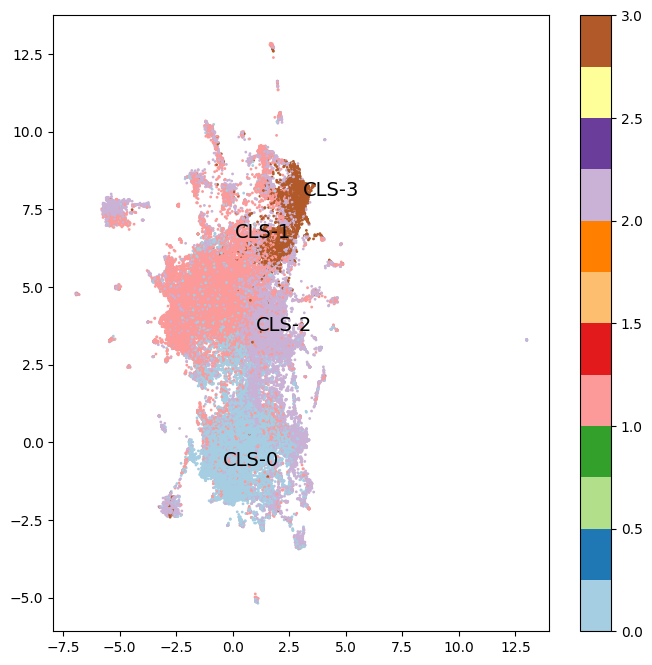

In [26]:
X = umap.UMAP(n_components=2,min_dist=0.0).fit_transform(corpus_embeddings)
labels= kmeans.labels_
print(labels)
fig, ax = plt.subplots(figsize=(8,8))
print(X[:,0])
plt.scatter(X[:,0], X[:,1], c=labels, s=1, cmap='Paired')
for c in centers:
    plt.text(X[centers[c],0], X[centers[c], 1],"CLS-"+ str(c), fontsize=14)
plt.colorbar()

In [27]:
# Add Cluster and embeddings as new columns in source dataframe
df_filtered['cluster'] = labels
df_filtered['embedding'] = corpus_embeddings.tolist()

#### Top Words per Clusters

In [28]:
# initialize
cv = CountVectorizer(stop_words='english') 
cv_matrix = cv.fit_transform(df_filtered['desc_without_stopwords']) 
# create document term matrix
df_dtm = pd.DataFrame(
    cv_matrix.toarray(), 
    index=df_filtered['desc_without_stopwords'].values, 
    columns=cv.get_feature_names_out()
)

df_dtm['cluster'] = labels

df_dtm.index.name = '_desc_'
df_word_count = df_dtm.groupby('cluster').sum().reset_index().melt(
    id_vars=['cluster'], var_name='_word_', value_name='_count_'
)

In [29]:
words_0 = df_word_count[df_word_count.cluster==0].sort_values(
    by=['_count_'], ascending=False).reset_index(drop=True)

words_0.head(5)

,cluster,_word_,_count_
0,0,flavors,13391
1,0,fruit,11600
2,0,palate,11126
3,0,finish,9446
4,0,acidity,9101


In [30]:
words_1 = df_word_count[df_word_count.cluster==1].sort_values(
    by=['_count_'], ascending=False).reset_index(drop=True)

words_1.head(5)

,cluster,_word_,_count_
0,1,flavors,24634
1,1,palate,17948
2,1,cherry,17470
3,1,black,16373
4,1,tannins,15262


In [31]:
words_2 = df_word_count[df_word_count.cluster==2].sort_values(
    by=['_count_'], ascending=False).reset_index(drop=True)

words_2.head(5)

,cluster,_word_,_count_
0,2,flavors,13428
1,2,wine,11612
2,2,fruit,11433
3,2,acidity,7045
4,2,cherry,6302


In [32]:
words_3 = df_word_count[df_word_count.cluster==3].sort_values(
    by=['_count_'], ascending=False).reset_index(drop=True)

words_3.head(5)

,cluster,_word_,_count_
0,3,cabernet,8808
1,3,sauvignon,5012
2,3,flavors,4133
3,3,blend,3557
4,3,black,3398


### Can we recommend (predict) wines based on a theoretical human's previous wine choices and the corresponding embeddings?

In [33]:
# remove trailing spaces from title column
df_filtered['title'] = df_filtered['title'].str.strip()

In [34]:
# remove special characters
df_filtered['variety'] = df_filtered['variety'].astype(str).apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))

In [35]:
varieties = df_filtered['variety'].unique()
print(sorted(varieties))

['Abouriou', 'Agiorgitiko', 'Aglianico', 'Aidani', 'Airen', 'Albana', 'Albanello', 'Albario', 'Albarossa', 'Aleatico', 'Alfrocheiro', 'Alicante', 'Alicante Bouschet', 'Aligot', 'Alvarelho', 'Alvarinho', 'AlvarinhoChardonnay', 'Ansonica', 'Anto Vaz', 'Apple', 'Aragonez', 'Aragons', 'Argaman', 'Arinto', 'Arneis', 'Asprinio', 'Assyrtico', 'Assyrtiko', 'Athiri', 'Austrian Red Blend', 'Austrian white blend', 'Auxerrois', 'Avesso', 'Azal', 'Babi', 'Babosa Negro', 'Bacchus', 'Baco Noir', 'Baga', 'BagaTouriga Nacional', 'Barbera', 'BarberaNebbiolo', 'Bastardo', 'Biancale', 'Biancolella', 'Bical', 'Black Monukka', 'Black Muscat', 'Blanc du Bois', 'Blatina', 'Blauburger', 'Blauburgunder', 'Blauer Portugieser', 'Blaufrnkisch', 'Boazkere', 'Bobal', 'BobalCabernet Sauvignon', 'Bombino Bianco', 'Bombino Nero', 'Bonarda', 'Bordeauxstyle Red Blend', 'Bordeauxstyle White Blend', 'Bovale', 'Brachetto', 'Bual', 'Cabernet', 'Cabernet Blend', 'Cabernet Franc', 'Cabernet FrancCabernet Sauvignon', 'Cabernet 

#### Fabricate a theoretical user's preferred wine

In [36]:
user0_fav_index = [10676]

df_user0_prefs = df_filtered.iloc[user0_fav_index].reset_index()

df_user0_prefs[['country','title','variety','taster_name','desc_without_stopwords','points','price']].head()

,country,title,variety,taster_name,desc_without_stopwords,points,price
0,Italy,La Castellina 2007 Squarcialupi Riserva (Chianti Classico),Sangiovese,NaN,"There's inky, raw feel riserva (Sangiovese blended tiny percentages Cabernet Sauvignon Merlot), followed candied cherry rum cake. It finishes sour bitter.",85,30.0


In [63]:
def recommend_items(item_embeddings, query_embedding, top_n):
    """
    Recommends top_n items based on cosine similarity between item embeddings and a query embedding.

    Args:
        item_embeddings (np.array): Array of item embeddings, where each row is an item embedding.
        query_embedding (np.array): Embedding of the query item or user preference.
        top_n (int): Number of recommendations to return.

    Returns:
        list: List of indices of the top_n recommended items.
    """
    similarities = cosine_similarity(query_embedding.reshape(1, -1), item_embeddings)[0]

    similarities_sort = sorted(similarities, reverse=True)
    top_similarity_scores = similarities_sort[:top_n]
    
    top_indices = np.argsort(similarities)[::-1][:top_n]
    top_similarity_scores_list = [float(x) for x in top_similarity_scores]
    print(f"Top {top_n} Similarity Scores: {top_similarity_scores_list}")
    return top_indices.tolist(), top_similarity_scores_list

df_filtered_less_pref = df_filtered.drop(index=user0_fav_index[0])
item_embeddings = np.array(df_filtered_less_pref['embedding'].to_list())
query_embedding = np.array(df_user0_prefs['embedding'].to_list())

top_recommendations, top_similarity_scores_list = recommend_items(item_embeddings, query_embedding, top_n=10)
print(f"Recommended item indices: {top_recommendations}")

Top 10 Similarity Scores: [0.7476273063269108, 0.7431905360160092, 0.7359015843866412, 0.7351104877038777, 0.7326148342482363, 0.7313839157234858, 0.7294299530193592, 0.7285765622038219, 0.727710940655117, 0.7255326563618866]
Recommended item indices: [93291, 8621, 64266, 15283, 101160, 10200, 98292, 92, 57009, 32950]


In [64]:
df_user0_reccs = df_filtered.iloc[top_recommendations]

df_user0_reccs['similarity_score'] = top_similarity_scores_list

print(f"For the preferred wine with title '{str(df_user0_prefs.loc[0, 'title'])}' and Variety: '{str(df_user0_prefs.loc[0, 'variety'])}', reviewed by '{str(df_user0_prefs.loc[0, 'taster_name'])}'  are:")

df_user0_reccs[['country','title','variety','taster_name','desc_without_stopwords','similarity_score','points','price']].head(10)

For the preferred wine with title 'La Castellina 2007 Squarcialupi Riserva  (Chianti Classico)' and Variety: 'Sangiovese', reviewed by 'nan'  are:


,country,title,variety,taster_name,desc_without_stopwords,similarity_score,points,price
93291,US,Terra Valentine 2011 Marriage Red (Spring Mountain District),Bordeauxstyle Red Blend,Virginie Boone,"Herbal peppercorn cradles soft composition oaky, structured backbone comprised 47% Merlot, 33% Cabernet Sauvignon 20% Cabernet Franc. Medium bodied, cranberry, tobacco plum play palate lengthy finish.",0.747627,88,90.0
8621,Italy,Tua Rita 2013 Rosso di Notri Red (Toscana),Red Blend,Kerin O’Keefe,"Made 50% Sangiovese blend Cabernet Sauvignon Merlot, vibrant red opens lovely dark-skinned berry, plum cake spice. The smooth, vibrant palate doles black cherries, crushed blackberries, dusty cocoa aniseed. It's nicely balanced racy acidity polished tannins. Drink 2018.",0.743191,91,20.0
64266,South Africa,Beyerskloof 2010 Reserve Pinotage (Stellenbosch),Pinotage,Lauren Buzzeo,"Ripe forest-fruit upfront, easily supporting ample woody spice toasted character. The palate fruit-forward, black plum core taking center stage licorice anise accents. The fine tannins juicy fruit flavors make approachable enjoyable now.",0.735902,88,30.0
15283,US,Glenora 2013 Chardonnay (Finger Lakes),Chardonnay,Anna Lee C. Iijima,"Green, herbaceous notes lemongrass accent steely, slightly nervy Chardonnay. While satisfyingly full body alcohol, refreshing cutting lemon-lime acidity highlighting fresh apple pear flavors.",0.735110,87,13.0
101160,Argentina,Verum 2011 Malbec (Alto Valle del Río Negro),Malbec,Michael Schachner,"The scratchy berry solid upfront—good enough urge swig wine. What comes next soupy, herbal, tomato-influenced Malbec finishes like gazpacho.",0.732615,82,17.0
10200,Italy,Tenuta Santavenere 2011 Poderuccio (Vino Nobile di Montepulciano),Red Blend,Kerin O’Keefe,"A blend 85% Sangiovese, 10% Merlot 5% Cabernet Sauvignon, conveys wood shop, mature plum, mint, crushed violet scorched earth. The palate offers dried black cherry, sensations cured meat roasted coffee bean alongside raspy, drying tannins. This already quite evolved.",0.731384,86,22.0
98292,US,La Chanterelle 2012 Cabernet Sauvignon (Walla Walla Valley (WA)),Cabernet Sauvignon,Paul Gregutt,"Young, tight sharp-toned upon first sniff, broadens opens hour two airing. The pinpoint focus brings black raspberry, black cherry light hints tobacco play. The 30% new oak seems right, although burn finish high alcohol.",0.729430,89,38.0
92,Italy,Marchesi de' Frescobaldi 2014 Castiglioni Red (Toscana),Red Blend,Kerin O’Keefe,"A blend Cabernet Sauvignon, Merlot, Cabernet Franc Sangiovese, pleasant red dark-skinned fruit, toast whiff espresso. The light-bodied, straightforward palate offers cherry, red currant hint light spice alongside zesty acidity polished tannins.",0.728577,87,30.0
57009,US,Cameron Hughes 2015 lot 533 Limestone Cowboy Chardonnay (Santa Barbara County),Chardonnay,Matt Kettmann,"Lots white flowers, jasmine lilies, show nose well-priced bottling, alongside poached pears lime sorbet. The palate packs tangy pungency, Anjou pear Granny Smith apple flavors.",0.727711,86,13.0
32950,Italy,Massolino 2011 Parussi (Barolo),Nebbiolo,Kerin O’Keefe,"This classic Barolo opens ripe dark berry, forest floor balsamic note. On palate, clove, pepper licorice back core crushed black cherry raspberry. It's young already remarkably well balanced, tightly knit, refined tannins nervous acidity. Drink 2019–2029.",0.725533,93,99.0


#### Limiting matches to similar descriptions cause the matching to lean toward wines from Tasters with similar description styles, so let's broaden the matching to use more embeddings

### Get embeddings for Variety and Title then Average embeddings

In [39]:
df_filtered2 = df_filtered

In [40]:
corpus_variety = df_filtered2['variety']
corpus_title = df_filtered2['title']

corpus_variety_embeddings = model.encode(corpus_variety) #TODO: add sleep() ?
corpus_title_embeddings = model.encode(corpus_title)

#### When averaging the embeddings, weight the descriptions at 1/2 and the Variety at 2 (variety is likely more important for a taste palette)

In [45]:
# Combine embeddings (e.g., by weighted averaging)
combined_embeddings = ((1/2)*corpus_embeddings + 2*corpus_variety_embeddings + corpus_title_embeddings) / 3

In [46]:
# add embeddings to dataframe
df_filtered2['combined_embedding'] = combined_embeddings.tolist()

In [65]:
df_filtered_less_pref = df_filtered2.drop(index=user0_fav_index[0])
df_user0_prefs = df_filtered2.iloc[user0_fav_index].reset_index()

item_embeddings2 = np.array(df_filtered_less_pref['combined_embedding'].to_list())
query_embedding2 = np.array(df_user0_prefs['combined_embedding'].to_list())

top_recommendations2, top_similarity_scores_list = recommend_items(item_embeddings2, query_embedding2, top_n=25)
print(f"Recommended item indices for combined embedding matching: {top_recommendations}")

Top 25 Similarity Scores: [0.9855558616382925, 0.9709393585271398, 0.9704010387293374, 0.9667398477594704, 0.9647448020175137, 0.9638000477152607, 0.9610500700095356, 0.961050067225578, 0.9601739526204108, 0.9600570831026721, 0.95899150193774, 0.95899150193774, 0.9586664027104866, 0.9586664027104866, 0.9580649975790427, 0.9578806796282968, 0.9571321119936009, 0.9568254878633307, 0.9567533812401817, 0.9566769071068834, 0.9556759537946681, 0.9555777653643202, 0.9551793684190841, 0.954905872913244, 0.9548560017605643]
Recommended item indices for combined embedding matching: [93291, 8621, 64266, 15283, 101160, 10200, 98292, 92, 57009, 32950]


In [75]:
df_user0_reccs2 = df_filtered2.iloc[top_recommendations2]
df_user0_reccs2['similarity_score'] = top_similarity_scores_list

print(f"Using Averaged Embeddings (Description, Variety, and Title), for the preferred wine with title '{str(df_user0_prefs.loc[0, 'title'])}' and Variety: '{str(df_user0_prefs.loc[0, 'variety'])}', reviewed by '{str(df_user0_prefs.loc[0, 'taster_name'])}' are (sorted by descending Points and acending Price):")

# Sort results by weighting between points and price to reccomend best options
weight_points = .5
weight_price = .5
df_user0_reccs2['weighted_customer_value'] = (df_user0_reccs2['points'] * weight_points) + -1*(df_user0_reccs2['price'] * weight_price)

df_sorted = df_user0_reccs2.sort_values(by=['weighted_customer_value'], ascending=[False])

df_sorted[['country','title','variety','taster_name','desc_without_stopwords','similarity_score','weighted_customer_value','points','price']].head(5)

Using Averaged Embeddings (Description, Variety, and Title), for the preferred wine with title 'La Castellina 2007 Squarcialupi Riserva  (Chianti Classico)' and Variety: 'Sangiovese', reviewed by 'nan' are (sorted by descending Points and acending Price):


,country,title,variety,taster_name,desc_without_stopwords,similarity_score,weighted_customer_value,points,price
58456,Portugal,Aveleda 2010 Follies Fonte Nossa Senhora da Vandoma Touriga Nacional-Cabernet Sauvignon Red (Beiras),Portuguese Red,Roger Voss,"Concentrated powerful, rich intense black-fruited wine. Notes spice, herb dark chocolate mingle flavor black plum juice firm, dry tannins. The result needs several years age.",0.960174,39.5,91,12.0
95186,Australia,Yellow Tail 2015 Pinot Grigio (South Eastern Australia),Pinot Grigio,Joe Czerwinski,"This inexpensive relatively low alcohol reasonably refreshing, although pear, melon pineapple flavors leave slightly sweet impression palate. Drink now.",0.958666,38.5,85,8.0
62884,Italy,Leone de Castris 2005 Villa Santera (Primitivo di Manduria),Primitivo,NaN,"This simple pleasant southern Italy sweet, floral tones cherry blossom, rose hip, lavender scented candle. The vibrant, pointed personality sour crispness close.",0.958992,36.5,85,12.0
76750,New Zealand,Brancott 2008 Reserve Sauvignon Blanc (Marlborough),Sauvignon Blanc,Joe Czerwinski,"Carves path right center Marlborough's stylistic fairway, featuring hints bell pepper, stone fruit wet-stone minerality. It's medium body, flavors nectarine, herbal flourishes dry, stony finish. Drink now.",0.966740,35.5,89,18.0
82672,New Zealand,Bird 2007 Old Schoolhouse Vineyard Pinot Gris (Marlborough),Pinot Gris,Joe Czerwinski,"A coppery tinge wine's hue suggests bit skin contact, show reminscent Pinot Noir—earth, spice underbrush. But offset ripe melon flavors finish clean refreshing, despite hint residual sugar. Consume next year two.",0.955578,34.0,89,21.0


### Next Steps: 
* Explore CatBoost or matrix factorization (would be depedent on multipler user choices) for a recommender system